In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=04bbde5392774724f00241badf248aac2a0baad3fc1e161ccc016a1fe43412c9
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col,count,when,isnan
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator
import pickle
import matplotlib.pyplot as plt

In [22]:
spark=SparkSession.builder.appName('my_app').getOrCreate()
df=spark.read.csv('/content/uber-raw-data-aug14.csv',header=True,inferSchema=True)
df.show()
num_columns = len(df.columns)
num_rows = df.count()
print("Number of columns:", num_columns)
print("Number of rows:", num_rows)

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

In [15]:
df.describe().show()

+-------+----------------+--------------------+-------------------+------+
|summary|       Date/Time|                 Lat|                Lon|  Base|
+-------+----------------+--------------------+-------------------+------+
|  count|          829275|              829275|             829275|829275|
|   mean|            null|   40.73778073582462| -73.97016031317625|  null|
| stddev|            null|0.043628060846868946|0.06148272834518351|  null|
|    min|8/1/2014 0:00:00|             39.6569|           -74.7737|B02512|
|    max|8/9/2014 9:59:00|             41.3182|           -72.3359|B02764|
+-------+----------------+--------------------+-------------------+------+



In [16]:
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print("Nulls:")
null_counts.show()
print("We have no null values in this dataset.")

Nulls:
+---------+---+---+----+
|Date/Time|Lat|Lon|Base|
+---------+---+---+----+
|        0|  0|  0|   0|
+---------+---+---+----+

We have no null values in this dataset.


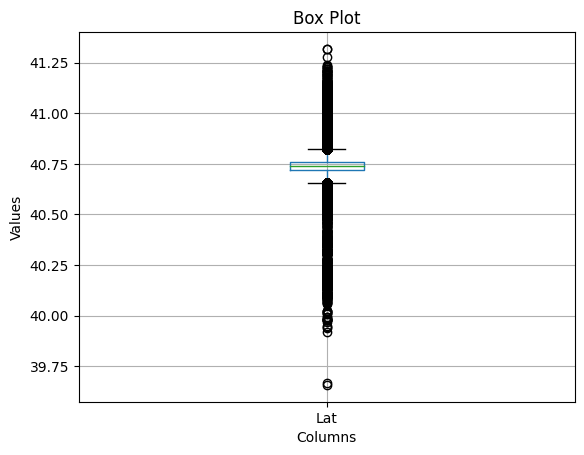

In [27]:
#پرت
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df.toPandas()

columns_for_boxplot = ['Lat']

pandas_df.boxplot(column=columns_for_boxplot)

plt.title('Box Plot')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.show()



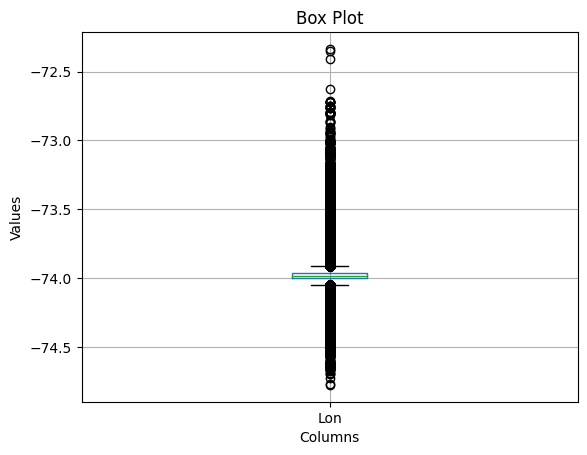

In [28]:
#پرت
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df.toPandas()

columns_for_boxplot = ['Lon']

pandas_df.boxplot(column=columns_for_boxplot)

plt.title('Box Plot')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.show()


In [20]:

cost = []

assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol='features')
data = assembler.transform(df.select('Lat', 'Lon'))

for i in range(2, 11):
    kmeans = KMeans(k=i, seed=0)
    model = kmeans.fit(data.select('Lat', 'Lon' , 'features'))
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print(f"silhouette coefficient in {i} = " + str(silhouette))
    cost.append(silhouette)


silhouette coefficient in 2 = 0.844170245743629
silhouette coefficient in 3 = 0.43946091940036947
silhouette coefficient in 4 = 0.8570580885453224
silhouette coefficient in 5 = 0.5558122297387842
silhouette coefficient in 6 = 0.5193684163386342
silhouette coefficient in 7 = 0.5252543378509391
silhouette coefficient in 8 = 0.5330680546952632
silhouette coefficient in 9 = 0.5689462089956616
silhouette coefficient in 10 = 0.575024829305516


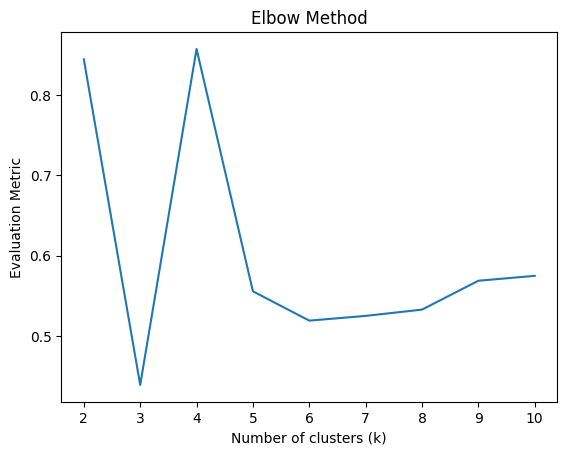

In [21]:
eval_metrics = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=0)
    model = kmeans.fit(data.select('Lat', 'Lon' , 'features'))
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    eval_metrics.append(silhouette)
plt.plot(range(2, 11), eval_metrics)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Evaluation Metric')
plt.title('Elbow Method')
plt.show()


In [34]:
#ساخت مدل
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=0)

kmeans = KMeans(k=5, seed=100)
model = kmeans.fit(trainingData)

predictions = model.transform(testData)

model.save('/content/my_model2')

In [35]:
testdatatocsv = testData.select('Lat','Lon')
testdatatocsv.write.csv('output.csv', header=True, mode='overwrite')